In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [2]:
# 遺伝子の読み込みおよび範囲の制限
gene = [
    -0.8087761869412128,
    -0.5187851715113809,
    -0.0240244826848366,
    0.8906090337388447,
    0.23156655385437283,
    0.16110649000847138,
    0.32829227306065917,
    0.014324879674408056,
    0.008159382101331726,
    -0.752459937531011,
    0.5171905159445384,
    0.46599802780160693,
    -0.6182012946538264,
    -0.12018898007398546,
    0.990638536768992,
    -0.7584833158075185,
    -0.5181087751046201,
    -0.792979780248935,
    0.2308170893882733,
    -0.7362952878908692,
    -0.08429466499689782,
    0.384498523972481,
]

In [3]:
def weight(gene):
    # 遺伝子の範囲を変更する
    def gene_range_1(gene, min, max):
        gene_ = (gene + 1) / 2 * (max - min) + min
        return gene_

    def gene_range_2(gene, min, max):
        gene_ = (gene + 1) / 2 * (max - min) + min
        return gene_, gene_

    # 遺伝子の引き渡し
    # 感覚ニューロン時間 0.1,4.2]
    N = gene_range_1(gene[0], 0.1, 4.2)
    M = gene_range_1(gene[1], 0.1, 4.2)

    # 介在ニューロンと運動ニューロンの閾値 [-15.15]
    theta = np.zeros(8)
    theta[0] = gene_range_1(gene[2], -15, 15)
    theta[1] = gene_range_1(gene[3], -15, 15)
    theta[2] = gene_range_1(gene[4], -15, 15)
    theta[3] = gene_range_1(gene[5], -15, 15)
    theta[4], theta[5] = gene_range_2(gene[6], -15, 15)
    theta[6], theta[7] = gene_range_2(gene[7], -15, 15)

    # 感覚ニューロンONの重み [-15.15]
    w_on = np.zeros(8)
    w_on[0] = gene_range_1(gene[8], -15, 15)
    w_on[1] = gene_range_1(gene[9], -15, 15)

    # 感覚ニューロンOFFの重み [-15.15]
    w_off = np.zeros(8)
    w_off[0] = gene_range_1(gene[10], -15, 15)
    w_off[1] = gene_range_1(gene[11], -15, 15)

    # 介在ニューロンと運動ニューロンのシナプス結合の重み [-15.15]
    w = np.zeros((8, 8))
    w[0, 2] = gene_range_1(gene[12], -15, 15)
    w[1, 3] = gene_range_1(gene[13], -15, 15)
    w[2, 4], w[2, 5] = gene_range_2(gene[14], -15, 15)
    w[3, 6], w[3, 7] = gene_range_2(gene[15], -15, 15)
    w[4, 4], w[5, 5] = gene_range_2(gene[16], -15, 15)
    w[6, 6], w[7, 7] = gene_range_2(gene[17], -15, 15)

    # 介在ニューロンと運動ニューロンのギャップ結合の重み [0.2.5]
    g = np.zeros((8, 8))
    g[0, 1], g[1, 0] = gene_range_2(gene[18], 0, 2.5)
    g[2, 3], g[3, 2] = gene_range_2(gene[19], 0, 2.5)

    # 運動ニューロンに入る振動成分の重み [0.15]
    w_osc = np.zeros(8)
    w_osc[4], w_osc[7] = gene_range_2(gene[20], 0, 15)
    w_osc[5], w_osc[6] = -w_osc[4], -w_osc[4]

    # 回転角度の重み [1,3]
    w_nmj = gene_range_1(gene[21], 1, 3)

    return N, M, theta, w_on, w_off, w, g, w_osc, w_nmj


# 塩濃度
def c(alpha, x_, y_, x_peak, y_peak):
    return alpha * np.sqrt((x_ - x_peak) ** 2 + (y_ - y_peak) ** 2)


# ON細胞
def y_on(c_t, N_, M_, N, M):
    y_ = np.sum(c_t[M_ : M_ + N_]) / N - np.sum(c_t[0:M_]) / M
    y_ = np.clip(y_, 0, None)
    return y_


# OFF細胞
def y_off(c_t, N_, M_, N, M):
    y_ = np.sum(c_t[0:M_]) / M - np.sum(c_t[M_ : M_ + N_]) / N
    y_ = np.clip(y_, 0, None)
    return y_


# シグモイド関数
def sigmoid(x):
    return np.exp(np.minimum(x, 0)) / (1 + np.exp(-np.abs(x)))


# 振動成分
def y_osc(t, T):
    return np.sin(2 * np.pi * t / T)


N, M, theta, w_on, w_off, w, g, w_osc, w_nmj = weight(gene)

# その他の定数
# alpha = random.uniform(-0.38, -0.01) #勾配を-0.38～-0.01の範囲でランダムに生成
alpha = -0.01
x_peak = 4.5  # 勾配のピークのx座標 /cm
y_peak = 0  # 勾配のピークのy座標 /cm
dt = 0.01  # 時間刻みの幅 /s
T = 4.2  # 移動の1サイクルの継続時間 /s
f = 0.033  # 方向の平均周波数 /Hz
v = 0.022  # 線虫の速度 /cm/s
time = 500  # シミュレート時間 /s
tau = 0.1  # 時定数 /s

# 時間に関する定数をステップ数に変換
N_ = np.floor(N / dt).astype(int)
M_ = np.floor(M / dt).astype(int)
f_inv = np.floor(1 / f / dt).astype(int)
T_ = np.floor(T / dt).astype(int)

# 各種配列の初期化
t = np.arange(0, time, dt)
c_t = np.zeros(N_ + M_)
c_t[0 : N_ + M_] = c(alpha, 0, 0, x_peak, y_peak)
y = np.zeros((8, len(t)))
y[4:8, 0] = np.random.rand(4)  # 運動ニューロンの活性を0～1の範囲でランダム化
phi = np.zeros(len(t))
mu = np.zeros(len(t))
# mu[0] = random.uniform(0, 2*np.pi) #ランダムな向きで配置
mu[0] = np.pi * 0.5
r = np.zeros((2, len(t)))

# オイラー法
for k in range(len(t) - 1):
    # シナプス結合およびギャップ結合からの入力
    synapse = np.dot(w.T, sigmoid(y[:, k] + theta))
    gap = np.array([np.dot(g[:, i], (y[:, k] - y[i, k])) for i in range(8)])

    # 濃度の更新
    c_t = np.delete(c_t, 0)
    c_t = np.append(c_t, c(alpha, r[0, k], r[1, k], x_peak, y_peak))

    # 介在ニューロンおよび運動ニューロンの膜電位の更新
    y[:, k + 1] = (
        y[:, k]
        + (
            -y[:, k]
            + synapse
            + gap
            + w_on * y_on(c_t, N_, M_, N, M)
            + w_off * y_off(c_t, N_, M_, N, M)
            + w_osc * y_osc(t[k], T)
        )
        / tau
        * dt
    )
    """
    #ピルエットの再現
    if k % f_inv == f_inv - 1:
        mu[k] = random.uniform(0, 2*np.pi)
    """

    # 方向の更新
    phi[k] = w_nmj * (
        sigmoid(y[5, k] + theta[5])
        + sigmoid(y[6, k] + theta[6])
        - sigmoid(y[4, k] + theta[4])
        - sigmoid(y[7, k] + theta[7])
    )
    mu[k + 1] = mu[k] + phi[k] * dt

    # 位置の更新
    r[0, k + 1], r[1, k + 1] = (
        r[0, k] + v * np.cos(mu[k]) * dt,
        r[1, k] + v * np.sin(mu[k]) * dt,
    )

# 走化性能指数の計算
ci = (
    1
    - np.sum(np.sqrt((r[0, :] - x_peak) ** 2 + (r[1, :] - y_peak) ** 2))
    / np.sqrt(x_peak**2 + y_peak**2)
    / time
    * dt
)
ci = np.clip(ci, 0, None)
print(ci)

0.6586393245133633


In [4]:
def Bear(t, T_, r, x_peak, y_peak):
    Bearing_point = []
    for i in range(len(t) - 2 * T_):
        Bearing_point.append([[r[0, i], r[1, i]], [r[0, i + T_], r[1, i + T_]]])
    Bearing_point = np.array(Bearing_point)
    Bearing = []

    for i in range(len(Bearing_point)):
        vec_1 = np.array([x_peak, y_peak])
        vec_2 = Bearing_point[i, 1] - Bearing_point[i, 0]
        angle = np.arccos(
            np.dot(vec_1, vec_2) / (np.linalg.norm(vec_1) * np.linalg.norm(vec_2))
        )
        angle = angle / np.pi * 180
        cross = np.cross(vec_1, vec_2)
        if cross < 0:
            angle *= -1
        Bearing.append(angle)

    Bearing = np.array(Bearing)
    return Bearing


def Turn_bias(t, T_, mu):
    Turning_bias = []
    for i in range(T_, len(t) - T_):
        Turning_bias.append(mu[i + T_] - mu[i])
    Turning_bias = np.array(Turning_bias)
    for i in range(len(Turning_bias)):
        if Turning_bias[i] > np.pi:
            Turning_bias[i] -= 2 * np.pi
    Turning_bias = Turning_bias / np.pi * 180
    return Turning_bias

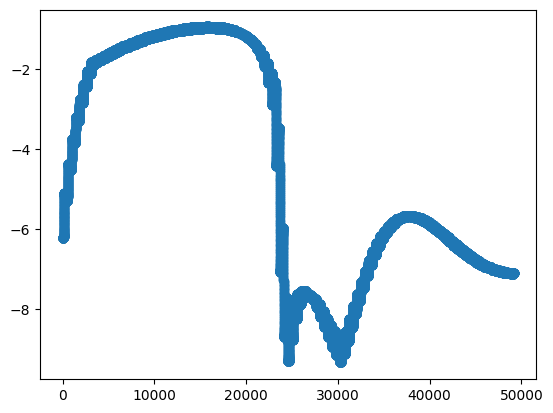

In [5]:
Bearing_ = Bear(t, T_, r, x_peak, y_peak).tolist()
Turning_bias_ = Turn_bias(t, T_, mu).tolist()

# plt.plot(Bearing_)
plt.scatter([i for i in range(len(Turning_bias_))], Turning_bias_)
# plt.ylim(-20,20)

In [6]:
Bearing = []
Turning_bias = []
for i in range(-180, 180, 10):
    mean = []
    for j in range(len(Bearing_)):
        if i < Bearing_[j] < (i + 10):
            mean.append(Turning_bias_[j])
    Bearing.append(i)
    Turning_bias.append(sum(mean) / len(mean))

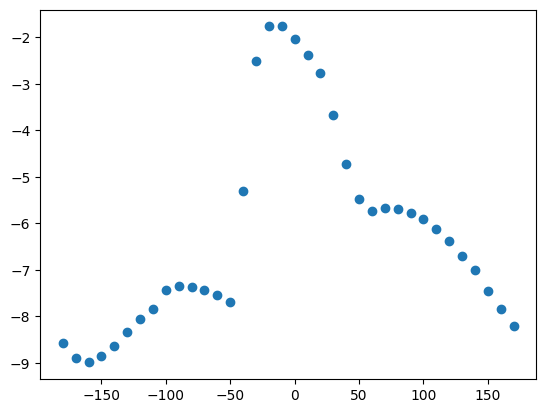

In [7]:
plt.scatter(Bearing, Turning_bias)

In [8]:
def test_run(gene, mu_0):
    def weight(gene):
        # 遺伝子の範囲を変更する
        def gene_range_1(gene, min, max):
            gene_ = (gene + 1) / 2 * (max - min) + min
            return gene_

        def gene_range_2(gene, min, max):
            gene_ = (gene + 1) / 2 * (max - min) + min
            return gene_, gene_

        # 遺伝子の引き渡し
        # 感覚ニューロン時間 0.1,4.2]
        N = gene_range_1(gene[0], 0.1, 4.2)
        M = gene_range_1(gene[1], 0.1, 4.2)

        # 介在ニューロンと運動ニューロンの閾値 [-15.15]
        theta = np.zeros(8)
        theta[0] = gene_range_1(gene[2], -15, 15)
        theta[1] = gene_range_1(gene[3], -15, 15)
        theta[2] = gene_range_1(gene[4], -15, 15)
        theta[3] = gene_range_1(gene[5], -15, 15)
        theta[4], theta[5] = gene_range_2(gene[6], -15, 15)
        theta[6], theta[7] = gene_range_2(gene[7], -15, 15)

        # 感覚ニューロンONの重み [-15.15]
        w_on = np.zeros(8)
        w_on[0] = gene_range_1(gene[8], -15, 15)
        w_on[1] = gene_range_1(gene[9], -15, 15)

        # 感覚ニューロンOFFの重み [-15.15]
        w_off = np.zeros(8)
        w_off[0] = gene_range_1(gene[10], -15, 15)
        w_off[1] = gene_range_1(gene[11], -15, 15)

        # 介在ニューロンと運動ニューロンのシナプス結合の重み [-15.15]
        w = np.zeros((8, 8))
        w[0, 2] = gene_range_1(gene[12], -15, 15)
        w[1, 3] = gene_range_1(gene[13], -15, 15)
        w[2, 4], w[2, 5] = gene_range_2(gene[14], -15, 15)
        w[3, 6], w[3, 7] = gene_range_2(gene[15], -15, 15)
        w[4, 4], w[5, 5] = gene_range_2(gene[16], -15, 15)
        w[6, 6], w[7, 7] = gene_range_2(gene[17], -15, 15)

        # 介在ニューロンと運動ニューロンのギャップ結合の重み [0.2.5]
        g = np.zeros((8, 8))
        g[0, 1], g[1, 0] = gene_range_2(gene[18], 0, 2.5)
        g[2, 3], g[3, 2] = gene_range_2(gene[19], 0, 2.5)

        # 運動ニューロンに入る振動成分の重み [0.15]
        w_osc = np.zeros(8)
        w_osc[4], w_osc[7] = gene_range_2(gene[20], 0, 15)
        w_osc[5], w_osc[6] = -w_osc[4], -w_osc[4]

        # 回転角度の重み [1,3]
        w_nmj = gene_range_1(gene[21], 1, 3)

        return N, M, theta, w_on, w_off, w, g, w_osc, w_nmj

    # 塩濃度
    def c(alpha, x_, y_, x_peak, y_peak):
        return alpha * np.sqrt((x_ - x_peak) ** 2 + (y_ - y_peak) ** 2)

    # ON細胞
    def y_on(c_t, N_, M_, N, M):
        y_ = np.sum(c_t[M_ : M_ + N_]) / N - np.sum(c_t[0:M_]) / M
        y_ = np.clip(y_, 0, None)
        return y_

    # OFF細胞
    def y_off(c_t, N_, M_, N, M):
        y_ = np.sum(c_t[0:M_]) / M - np.sum(c_t[M_ : M_ + N_]) / N
        y_ = np.clip(y_, 0, None)
        return y_

    # シグモイド関数
    def sigmoid(x):
        return np.exp(np.minimum(x, 0)) / (1 + np.exp(-np.abs(x)))

    # 振動成分
    def y_osc(t, T):
        return np.sin(2 * np.pi * t / T)

    N, M, theta, w_on, w_off, w, g, w_osc, w_nmj = weight(gene)

    # その他の定数
    # alpha = random.uniform(-0.38, -0.01) #勾配を-0.38～-0.01の範囲でランダムに生成
    alpha = -0.01
    x_peak = 4.5  # 勾配のピークのx座標 /cm
    y_peak = 0  # 勾配のピークのy座標 /cm
    dt = 0.01  # 時間刻みの幅 /s
    T = 4.2  # 移動の1サイクルの継続時間 /s
    f = 0.033  # 方向の平均周波数 /Hz
    v = 0.022  # 線虫の速度 /cm/s
    time = 300  # シミュレート時間 /s
    tau = 0.1  # 時定数 /s

    # 時間に関する定数をステップ数に変換
    N_ = np.floor(N / dt).astype(int)
    M_ = np.floor(M / dt).astype(int)
    f_inv = np.floor(1 / f / dt).astype(int)

    # 各種配列の初期化
    t = np.arange(0, time, dt)
    c_t = np.zeros(N_ + M_)
    c_t[0 : N_ + M_] = c(alpha, 0, 0, x_peak, y_peak)
    y = np.zeros((8, len(t)))
    y[4:8, 0] = np.random.rand(4)  # 運動ニューロンの活性を0～1の範囲でランダム化
    mu = np.zeros(len(t))
    # mu[0] = random.uniform(0, 2*np.pi) #ランダムな向きで配置
    mu[0] = mu_0
    r = np.zeros((2, len(t)))

    # オイラー法
    for k in range(len(t) - 1):
        # シナプス結合およびギャップ結合からの入力
        synapse = np.dot(w.T, sigmoid(y[:, k] + theta))
        gap = np.array([np.dot(g[:, i], (y[:, k] - y[i, k])) for i in range(8)])

        # 濃度の更新
        c_t = np.delete(c_t, 0)
        c_t = np.append(c_t, c(alpha, r[0, k], r[1, k], x_peak, y_peak))

        # 介在ニューロンおよび運動ニューロンの膜電位の更新
        y[:, k + 1] = (
            y[:, k]
            + (
                -y[:, k]
                + synapse
                + gap
                + w_on * y_on(c_t, N_, M_, N, M)
                + w_off * y_off(c_t, N_, M_, N, M)
                + w_osc * y_osc(t[k], T)
            )
            / tau
            * dt
        )
        """
        #ピルエットの再現
        if k % f_inv == f_inv - 1:
            mu[k] = random.uniform(0, 2*np.pi)
        """

        # 方向の更新
        mu[k + 1] = (
            mu[k]
            + w_nmj
            * (
                sigmoid(y[5, k] + theta[5])
                + sigmoid(y[6, k] + theta[6])
                - sigmoid(y[4, k] + theta[4])
                - sigmoid(y[7, k] + theta[7])
            )
            * dt
        )

        # 位置の更新
        r[0, k + 1], r[1, k + 1] = (
            r[0, k] + v * np.cos(mu[k]) * dt,
            r[1, k] + v * np.sin(mu[k]) * dt,
        )

    return r, mu

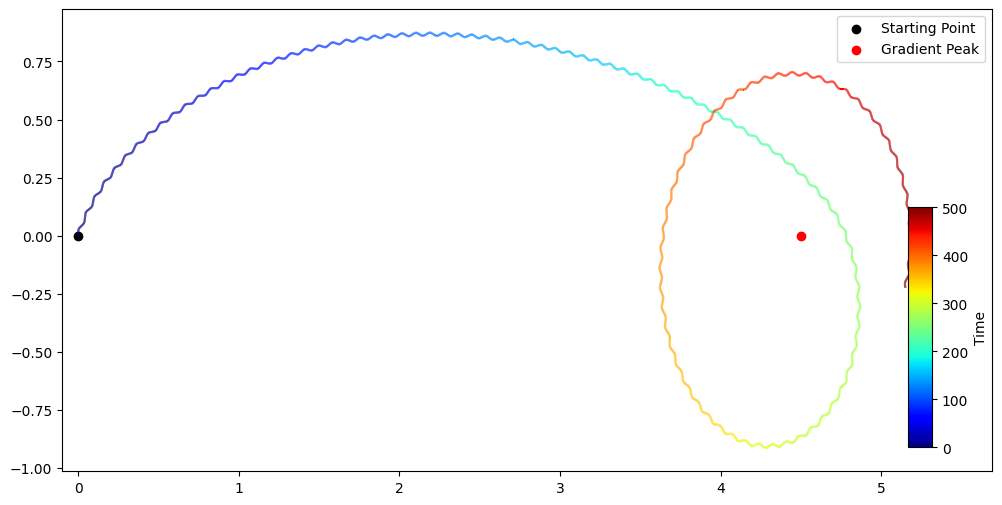

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection

fig1 = plt.figure(figsize=(12, 6))
ax1 = fig1.add_subplot(111)

# Starting Point と Gradient Peak の座標を設定
starting_point = [0, 0]
x_peak, y_peak = [x_peak, y_peak]

# Starting Point と Gradient Peak をプロット
ax1.scatter(*starting_point, color="black", label="Starting Point")
ax1.scatter(x_peak, y_peak, color="red", label="Gradient Peak")

segments = []
for n in np.arange(len(t) - 1):
    segments.append(np.array([[r[0, n], r[1, n]], [r[0, n + 1], r[1, n + 1]]]))

lc = LineCollection(segments, cmap="jet", linewidth=1.5)
cols = np.linspace(0, time, len(segments))
lc.set_array(cols)

ax1.add_collection(lc)

# x軸とy軸の範囲を設定
ax1.set_xlim(np.min(r[0]) - 0.1, np.max(r[0]) + 0.5)
ax1.set_ylim(np.min(r[1]) - 0.1, np.max(r[1]) + 0.1)

# カラーバーを追加し、位置をフィギュア内の右下に指定
cax = fig1.add_axes([0.83, 0.15, 0.02, 0.4])  # [left, bottom, width, height]
colorbar = plt.colorbar(lc, cax=cax)  # shrink パラメータでサイズを調整
colorbar.set_label("Time")  # カラーバーのラベルを設定

# 凡例を表示
ax1.legend()

plt.show()